# Exercise 4.2 - Word Sense Disambiguation

In Exercise 4.2, we will introduce a new natural language processing task to figure out which meaning of a word is present in a given context. This task is known as Word Sense Disambiguation. Knowing the correct meaning, or _sense,_ of a word is useful for many downstream NLP tasks like translation or question answering. Often, sense-tagged text is used as an intermediate representation for later NLP tasks too, like reasoning about sentences.

How do we humans disambiguate? We often make a choice for the correct sense considering other information from context, which includes not only the sentence with the word, but the larger document, the author, and our world knowledge. In this exercise, you'll try two WSD approaches to solving the task: 
  * A supervised learning approach that uses the classic Logistic Regression that you have used in previous assignments
  * A knowledge-based approach that doesn't rely on machine learning and instead relies on information from an external knowledge base  

The second approach will use the Lesk algorithm, which despite being proposed in 1980s is still considered a reasonable baseline for testing. In this exercise's setup, both approaches will look only at the containing-sentence as context.

Let's see how it will perform on our dataset, which will be derived from SemCor, a subsection of the Brown Corpus (American English from the 1960s) where all content words are tagged with their WordNet senses. 

This exercise has the following learning goals:
* Familiarize you with knowledge-based approaches to NLP
* Practice using supervised machine learning (this time for a semantic task)
* Learn how to work with WordNet and SemCor data structures
* Familiarize yourself with NLTK methods, which is another common NLP library 

In [1]:
import pandas as pd
from collections import Counter, defaultdict
from nltk.corpus import semcor
from nltk.corpus import wordnet as wn
from nltk.corpus.reader.wordnet import Lemma
from nltk.tree import Tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Set the random seed to 655 for the convenience of replication.

In [2]:
RANDOM_SEED = 655

## Data Preparation

In Exercise 4.2, we will use the SemCor corpus as our dataset. SemCor is a semantically annotated English corpus, and it can be directly imported via NLTK. Words in SemCor are annotated using WordNet synsets. To load annotated sentences in SemCor, we can simply call `semcor.tagged_sents()`. Besides sense annotations, SemCor words are also annotated with part-of-speech. Since we will focus on word sense disambugation in this exercise, we only need to pull out sense annotations, calling `semcor.tagged_sents(tag='sem')`.

The returned sentences from `semcor.tagged_sents(tag='sem')` are in the format of lists of trees. Each sentence is represented as a list of trees (Tree is a special data structure in NLTK). To make them more model-friendly, we will generate two lists for each sentence - a list of words in the sentence and a list of corresponding senses for each word in the sentence. Clearly, they should have the same length.

The ultimate goal of the data preparation is to make (features, label) pairs from the SemCor corpus as our train/test data. Each (ambiguous) word contributes to a datapoint. The label is the sense of the (ambiguous) word, and the features consist of the context words of the (ambiguous) word in the sentence.

In [3]:
semcor_tagged_sents = semcor.tagged_sents(tag='sem')

Let's look at one example of a tagged sentence to have a sense of "a list of trees".

In [4]:
semcor_tagged_sents[0]

[['The'],
 Tree(Lemma('group.n.01.group'), [Tree('NE', ['Fulton', 'County', 'Grand', 'Jury'])]),
 Tree(Lemma('state.v.01.say'), ['said']),
 Tree(Lemma('friday.n.01.Friday'), ['Friday']),
 ['an'],
 Tree(Lemma('probe.n.01.investigation'), ['investigation']),
 ['of'],
 Tree(Lemma('atlanta.n.01.Atlanta'), ['Atlanta']),
 ["'s"],
 Tree(Lemma('late.s.03.recent'), ['recent']),
 Tree(Lemma('primary.n.01.primary_election'), ['primary', 'election']),
 Tree(Lemma('produce.v.04.produce'), ['produced']),
 ['``'],
 ['no'],
 Tree(Lemma('evidence.n.01.evidence'), ['evidence']),
 ["''"],
 ['that'],
 ['any'],
 Tree(Lemma('abnormality.n.04.irregularity'), ['irregularities']),
 Tree(Lemma('happen.v.01.take_place'), ['took', 'place']),
 ['.']]

The output above might look intimidating. Don't worry about that! Below is some code to generate the two lists we want for each sentence. You can check the code inside the second for-loop to have some idea how to interact with and extract the information from a tree. The following code works on generating two lists for each sentence and saving them as a tuple (list A, list B) into an overall list `list_of_lemmas_and_senses`.

* List A - a list of words in the sentence
* List B - a list of annotated senses for each word in the sentence

### Task 4.2.1: Create a dataset for WSD from SemCor
SemCor by itself doesn't have a dataset, so we'll create one to use for the purposes of this exercise. Here, we'll loop through all the SemCore tagged sentences and extract a list of senses and lemmas (and their parts of speech) in each sentence.

Complete the following code by filling in the TODO section

Note: this is the longest section of the exercise and can take ~3 minutes

In [5]:
list_of_lemmas_and_senses = []

for sent in tqdm(semcor_tagged_sents):
    # List of (lemma, pos) tuples
    lemmas = []
    senses = []
    
    for constituent in sent:
        if isinstance(constituent, Tree):
            if isinstance(constituent.label(), Lemma):
                # Most sense-tagged lemmas have a name like "analyze.v.01.study"
                # The first three parts are the synset by sense number and the fourth
                # is the lemma form of the current word, which is what we want.
                #
                # Sometimes it only has three parts, in which case we use the first
                label_components = constituent.label().synset().name().split('.')
                if len(label_components) != 4:               
                    curr_lemma = label_components[0]
                else:
                    curr_lemma = label_components[3]
                curr_pos = label_components[1]

                corresponding_sense = constituent.label().synset()
                
                # TODO: append the current word and its parts of speech (as a tuple) 
                # to 'lemmas' and append the corresponding sense to 'senses'
                # YOUR CODE HERE
                lemmas.append((curr_lemma, curr_pos))
                senses.append(corresponding_sense)
            else:
                lemmas += [(w, 'other') for w in constituent.leaves()]
                senses += [None] * len(constituent.leaves())
        else:
            lemmas += [(w, 'other') for w in constituent]
            senses += [None] * len(constituent)
    
    list_of_lemmas_and_senses.append((lemmas, senses))

100%|██████████| 37176/37176 [00:27<00:00, 1344.50it/s]


After we have `list_of_lemmas_and_senses`, we are a huge step closer to the ultimate goal of data preparation. The next step is to generate the labeled data for each word. For each datapoint/word, the features are the context words of the current word, and the label is the correct sense of the current word. We also keep the current word along with its sense and features so that we can check word frequencies later, so as to include only the most common 100 words. There are several reasons to only include 100 most frequent words:
* 1) The frequency distribution of words generally follows the Zipf's Law, so there is a lot of words with low frequency, which means there is not enough train/test data for those words.
* 2) Including all the words will make the train/test data super large, which might exceed the running memory limit of the server, though most of words don't even have enough train/test data.

In [6]:
data = []

for lemmas_pos, senses in tqdm(list_of_lemmas_and_senses):
    lemmas = [lp[0] for lp in lemmas_pos]
    for i, (lemma, pos) in enumerate(lemmas_pos):
        # Check whether this lemma had a sense, and if not, skip it
        if senses[i] is None:
            continue
            
        context = ' '.join(lemmas[:i] + lemmas[(i + 1):])
        correct_sense = senses[i].name()
        # Out of convenience, we'll join the lemma and part of speech together into
        # a single string, which lets us keep the contexts distinct for words with
        # more than one part of speech
        data.append([lemma + '.' + pos, context, correct_sense])

100%|██████████| 37176/37176 [00:00<00:00, 37261.69it/s]


Convert the data into a pandas dataframe.

In [7]:
data_df = pd.DataFrame(data=data, columns=['lemma.pos', 'context', 'sense'])

### Task 4.2.2: Print the dataset size

In [8]:
print(len(data_df)) # should be 224716
# hidden tests are within this cell

224716


Let's do a sanity check for the first 10 datapoints.

In [9]:
data_df.head(10)

,lemma.pos,context,sense
0,group.n,The state friday an probe of atlanta 's late p...,group.n.01
1,state.v,The group friday an probe of atlanta 's late p...,state.v.01
2,friday.n,The group state an probe of atlanta 's late pr...,friday.n.01
3,probe.n,The group state friday an of atlanta 's late p...,probe.n.01
4,atlanta.n,The group state friday an probe of 's late pri...,atlanta.n.01
5,late.s,The group state friday an probe of atlanta 's ...,late.s.03
6,primary.n,The group state friday an probe of atlanta 's ...,primary.n.01
7,produce.v,The group state friday an probe of atlanta 's ...,produce.v.04
8,evidence.n,The group state friday an probe of atlanta 's ...,evidence.n.01
9,abnormality.n,The group state friday an probe of atlanta 's ...,abnormality.n.04


### Task 4.2.3: Print the most common 100 annotated lemmas in the SemCor corpus.

There are a lot of lemmas in our dataset&mdash;in fact WordNet contains hundreds of thousand words. To keep things simple for this exercise, we will only use the most common 100 of them. Let's print them out to see how they look.

In [10]:
lemma_counts = Counter(data_df['lemma.pos'])
top_100_lemmas = lemma_counts.most_common(100)
#hidden tests are within this cell
top_100_lemmas

[('be.v', 14586),
 ('person.n', 6768),
 ('state.v', 1945),
 ('make.v', 1758),
 ('not.r', 1703),
 ('have.v', 1701),
 ('group.n', 1338),
 ('location.n', 989),
 ('look.v', 974),
 ('know.v', 883),
 ('exist.v', 814),
 ('see.v', 744),
 ('use.v', 720),
 ('become.v', 687),
 ('think.v', 616),
 ('two.s', 571),
 ('give.v', 564),
 ('then.r', 542),
 ('besides.r', 541),
 ('merely.r', 514),
 ('one.s', 513),
 ('time.n', 499),
 ('man.n', 492),
 ('ask.v', 470),
 ('come.v', 462),
 ('so.r', 460),
 ('get_down.v', 454),
 ('find.v', 444),
 ('other.a', 442),
 ('even.r', 436),
 ('year.n', 425),
 ('get.v', 423),
 ('leave.v', 413),
 ('put.v', 410),
 ('desire.v', 395),
 ('travel.v', 393),
 ('try.v', 393),
 ('more.r', 387),
 ('take.v', 372),
 ('happen.v', 353),
 ('supply.v', 352),
 ('necessitate.v', 344),
 ('continue.v', 337),
 ('keep.v', 335),
 ('day.n', 334),
 ('bring.v', 331),
 ('let.v', 325),
 ('determine.v', 320),
 ('feel.v', 318),
 ('understand.v', 314),
 ('many.a', 309),
 ('arrive.v', 306),
 ('learn.v', 296

## Use Two Approaches to Resolving Word Sense Disambiguation

The data we need has been ready. That's great! Now we can move forward to solve the word sense disambuguation task. Here we will introduce two approaches -
* Supervised learning approach
* Knowledge-based approach

Supervised learning approach has the training process. After it recognizes the pattern in the training data, it will be able to apply what it learns to make predictions on the test data. Knowledge-based approach doesn't have the training process. Instead, it has its own knowledge base. In the scenario here, the knowledge base is the definition of each sense of each word provided by WordNet. Knowledge-based approach makes it prediction with the help of its knowledge base. Specifically, the supervised learning approach we will use is **Logistic Regression**, and the knowledge-based approach we will use is the **Lesk** algorithm. We will use both of these two approaches to predict word senses and then compare their performance.

## Supervised Learning Approach - Logistic Regression

For the supervised learning approach, we come back to our old friend - logistic regression. Tfidf vectorizer will be used to transform the textual data into a model-friendly matrix of Tfidf features. We split datapoints for each word into train and test by the ratio of 80/20, and train separate classifiers for each word.

### Task 4.2.4: Create a Tfidf vectorizer that we will use to convert context words into model-friendly features.

Create a Tfidf vectorizer that will remove stopwords and any words whose document frequency is less than 500. 

We're keeping this classifier simple for testing purposes, but you are welcome to explore the effects of different hyperparameter settings. What happens if you allow for more features?

In [11]:
# TODO - create a Tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=500)

vectorizer.fit(data_df['context'].tolist())

TfidfVectorizer(min_df=500, stop_words='english')

### Task 4.2.5: Complete function `generate_train_test_data_for_each_word`

`generate_train_test_data_for_each_word` takes a word and the `data_df` data frame as the input. First, it extracts datapoints associated with the word (i.e. the label of the datapoint is a sense associated with the word). Then, it splits the data using `train_test_split` with a 80%-train-20%-test ratio and the preset `RANDOM_SEED` as the random_state. Last, it returns X_train, X_test, y_train, and y_test produced by `train_test_split`.

In [12]:
'''
params:
  lemma_pos: the current lemma and its POS as a string (e.g., "become.v")
  data_df: data frame for all datapoints [lemma, context, sense]
return:
  X_train: list of contexts, each as a string
  X_test: list of contexts, each as a string
  y_train: list of senses, each as a string
  y_test: list of senses, each as a string
if there is only a single annotated sense for the current lemma, skip the lemma
'''
def generate_train_test_data_for_each_lemma(lemma_pos, data_df):
    lemma_df = data_df[data_df['lemma.pos'] == lemma_pos]

    # if there is only one class, return None's to indicate no need to train a classifier
    if len(lemma_df['sense'].unique()) < 2:
        return [None] * 4

    X = lemma_df['context'].tolist()
    y = lemma_df['sense'].tolist()
    # TODO - split the datapoints with a 80%-train-20%-test ratio and the preset `RANDOM_SEED` as the random_state
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

    return X_train, X_test, y_train, y_test

### Task 4.2.6: Complete function `train_classifiers_for_each_lemma`

`train_classifiers_for_each_lemma` takes the most common 100 words, the `data_df` dataframe, and the Tfidf vectorizer that has been done fitting as parameters. It iterates through the words given and trains a classifier for each word. We save the trained classifiers in a dictionary `clf_dict` - with word as key and its classifier as value. We also save the test data for each word in a dictionary `test_data_dict` - with word as key and a tuple (`X_test`, `y_test`) as value. The reason why we save them is that we will use them as the test data for the knowledge-based approach. We make sure the test data is the same for a fair comparison.

In [13]:
'''
params:
  lemmas_with_pos: a  list of the current lemmas and their POS 
  data_df: data frame for all datapoints [word, context, sense]
  vectorizer: Tfidf vectorizer that has been fit on all contexts from the Semcor corpus
return:
  clf_dict: key-value as {word: its specific trained classifier}
  test_data_dict: key-value as {word: (test_features, test_labels)}
'''
def train_classifiers_for_each_lemma(lemmas_with_pos, data_df, vectorizer):
    clf_dict = {}
    test_data_dict = {}

    for lemma_pos in tqdm(lemmas_with_pos):
        X_train, X_test, y_train, y_test = generate_train_test_data_for_each_lemma(lemma_pos, data_df)

        # X_train is None indicates that there is only one class for the current word.
        # It's meaningless to train such a classifier, so we will use 'continue' to skip.
        if X_train is None:
            continue

        clf = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000, random_state=RANDOM_SEED)
        
        # TODO - fit the classifier (don't forget to use vectorizer to transform X_train)
        X_train_new = vectorizer.transform(X_train)
        fit_lr = clf.fit(X_train_new, y_train)
        
        # TODO - save the 'clf' into 'clf_dict'
        clf_dict[lemma_pos] = clf
        
        # TODO - save the tuple (X_test, y_test) into 'test_data_dict'
        test_data_dict[lemma_pos] = (X_test, y_test)

    return clf_dict, test_data_dict

Let's begin training 100 classifiers for the most common 100 annotated words, with each word having one classifier.

In [14]:
clf_dict, test_data_dict = train_classifiers_for_each_lemma([x[0] for x in top_100_lemmas], data_df, vectorizer)

100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


Let's evaluate the performance of our trained classifiers on their corresponding test data. Here we use `clf.score()` as the metric, which returns accuracy. For each word, we save the classification result into `clf_results`.

### Task 4.2.7: Complete the following code for evaluating supervised learning approach

In [15]:
clf_results = {}

for lemma_pos, clf in tqdm(clf_dict.items()):
    
    # TODO - retrieve the data from 'test_data_dict' for X_test and y_test
    X_test = test_data_dict[lemma_pos][0]
    y_test = test_data_dict[lemma_pos][1]
    
    clf_results[lemma_pos] = clf.score(vectorizer.transform(X_test), y_test)

100%|██████████| 79/79 [00:00<00:00, 317.23it/s]


In [16]:
clf_results

{'be.v': 0.674252810529202,
 'make.v': 0.5636363636363636,
 'have.v': 0.7230046948356808,
 'group.n': 0.991044776119403,
 'look.v': 0.7950819672131147,
 'know.v': 0.6153846153846154,
 'exist.v': 0.9705882352941176,
 'see.v': 0.6559139784946236,
 'use.v': 0.9555555555555556,
 'become.v': 0.6453488372093024,
 'think.v': 0.4805194805194805,
 'give.v': 0.3546099290780142,
 'then.r': 0.6617647058823529,
 'besides.r': 0.9779411764705882,
 'one.s': 0.9922480620155039,
 'time.n': 0.4,
 'man.n': 0.9024390243902439,
 'ask.v': 0.576271186440678,
 'come.v': 0.5258620689655172,
 'so.r': 0.6260869565217392,
 'get_down.v': 0.9912280701754386,
 'find.v': 0.4774774774774775,
 'even.r': 0.8807339449541285,
 'year.n': 0.9906542056074766,
 'get.v': 0.5754716981132075,
 'leave.v': 0.3942307692307692,
 'put.v': 0.8349514563106796,
 'desire.v': 1.0,
 'travel.v': 0.9595959595959596,
 'try.v': 1.0,
 'more.r': 0.9175257731958762,
 'take.v': 0.3548387096774194,
 'happen.v': 0.7865168539325843,
 'necessitate.v': 

## Knowledge Based Approach - Lesk

The Lesk algorithm will be used as the knowledge-based approach in this assignment. The idea behind Lesk is  straight-forward: Given a word in a sentence, for the WordNet Synset definition of each sense of that word, we compute the number of words in common between the context and the word's WordNet Synset definition. The sense, whose definition has the most number of words in common with the context of the given word, will be considered the correct sense for the given word.

For example:
(this is an artificial example only for easy demonstration. The definitions in the knowledge base are actually different)

> The word "apple" has two senses: 1) a kind of fruit 2) a kind of tree 2) a tech company.<br>
>
> Given a sentence: "I buy tech products in an apple store".<br>
>
> What does the "apple" mean here? A kind of fruit, a kind of tree, or a tech company? The answer given by Lesk will be 3) a tech company. The reason is that the context \["I", "buy", "tech", ""products", "in", "an", "store"\] has **one** word in common with definition 3), which is the greatest number in all definitions.

In this assignment, we will tweak the original Lesk algorithm to expand the definition of context. Since WordNet contains other types of information like example uses of each sense, it's common to include these examples as "extended glosses" when comparing with the sentence.

What do we do if the context has no overlap with any of the senses' information? In such cases, we can take advantage of the structure of WordNet itself! WordNet was designed to order senses by frequency so that the most common sense is the first sense (though this is not _always_ true in practice). In our implementation, if nothing matches, we can simply return the first sense.

We'll want to lemmatize the context, so we've provided a helper function for you below that will convert a context to a list of its lemmas.

In [17]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

# NLTK uses a more expressive POS tag set than WordNet, which uses only four categories.
# This function maps anything POS-tagged with NLTK to a POS tag that WordNet can recognize
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  

    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

## Task 4.2.8: Complete function `customized_lesk`

`customized_lesk` takes the context (string) and the word, and returns the predicted sense. Remember, it considers the sense whose definition has the most common words with the context as the correct one. If all definitions have 0 words in common with the context, it returns the most frequent sense in our knowledge base.

In [18]:
'''
params:
  context: <string> the context of the given word in the sentence
  word: <string> the given (ambiguous) word
return:
  pred_sense: <string> the correct sense produced by our self-made customized Lesk
'''
def customized_lesk(context, word, pos):
    context_words = context.lower().split()
    senses = wn.synsets(word, pos=pos)
    max_overlap = 0
    pred_sense = None
    
    for sense in senses:

        # This is a definition of the sense as a string
        definition = sense.definition()
        # This is a list of example sentences 
        examples = sense.examples()

        # TODO: check for the term-level overlap between the sentence context
        # and current sense's *expanded gloss* which includes its definition and all
        # the examples for the sense. In comparing, you'll want to lemmatize the
        # content in the expanded gloss using the lemmatize_sentence() function 
        # and make sure everything is lower case to maximize the potential for 
        # overlap. Note that we're computing the overlap over the unique words.
        #
        # If the current sense has more overlap than the previous-best match
        # update the previous max_overlap and pred_sense
        
        #HINT: Create a lesk context list
        lesk_context = []
        #HINT: Extend this list upon the lemmative_sentence function while passing the current definition as the parameter
        lesk_context.extend(lemmatize_sentence(definition))
        #HINT: iterate through each item in examples:
            #HINT: once again, extend the context list over lemmetize_sentence using the current team
        for item in examples:
            lesk_context.extend(lemmatize_sentence(item))
        
        #HINT: The context list should only include lower case words
        lesk_context = [word.lower() for word in lesk_context]
        #Create a count variable equal to the number of commonalities of contect_words and the context list you created
        count = len(set(context_words) & set(lesk_context))
        #HINT: If our count is greater than max_overlap:
        if count > max_overlap:
            #HINT: Redefine max_overlap to our new maximum (count)
            max_overlap = count
            #HINT: Redefine pred_sense as our current sense 
            pred_sense = sense
        
    # If nothing matched, guess the most frequent sense, which is typically 
    # the first sense in the database (as designed in WordNet)
    if max_overlap == 0:
        pred_sense = senses[0]
    
    #print(pred_sense, max_overlap)
    return pred_sense.name()

### Task 4.2.9: Complete the following code for evaluating Lesk WSD
Note that this cell can take ~3 minutes.

In [19]:
lesk_results = {}

# import nltk
# nltk.download('averaged_perceptron_tagger')

for word_pos in tqdm(test_data_dict):
    correct = 0
    total = 0
    

    # TODO - retrieve the data from 'test_data_dict' for X_test and y_test
    X_test = test_data_dict[word_pos][0]
    y_test = test_data_dict[word_pos][1]

    word, pos = word_pos.split('.')
    
    for i in range(len(X_test)):
        ### TODO - uncomment and finish the following line
        # pred_sense = customized_lesk(______, ______)
        pred_sense = customized_lesk(X_test[i], word, pos)
        
        if pred_sense == y_test[i]:
            correct += 1
        total += 1

    lesk_results[word] = correct / total

100%|██████████| 79/79 [03:06<00:00,  2.36s/it] 


## Comparison: Supervised Learning Approach VS. Knowledge Based Approach

In [20]:
comparison_df = pd.DataFrame() # columns=['lemma',  'LogReg score','Lesk score',])

In [21]:
comparison_df['lemma'] = sorted(list(clf_results.keys()))
comparison_df['LogReg score'] = [item[1] for item in sorted(clf_results.items(), key=lambda x: x[0])]
comparison_df['Lesk score'] = [item[1] for item in sorted(lesk_results.items(), key=lambda x: x[0])]

### Task 4.2.10: Print the accuracy score of supervised learning approach for word "group"

In [22]:
print(comparison_df[comparison_df['lemma']=='group.n']['LogReg score'].values[0])
# hidden tests are within this cell

0.991044776119403


### Task 4.2.11: Print the accuracy score of knowledge-based approach for word "group"

In [23]:
print(comparison_df[comparison_df['lemma']=='group.n']['Lesk score'].values[0])
# hidden tests are within this cell

0.21492537313432836


### Task 4.2.12: Print the accuracy score of supervised learning approach for word "become"

In [24]:
print(comparison_df[comparison_df['lemma']=='become.v']['LogReg score'].values[0])
# hidden tests are within this cell

0.6453488372093024


### Task 4.2.13: Print the accuracy score of knowledge-based approach for word "become"

In [25]:
print(comparison_df[comparison_df['lemma']=='become.v']['Lesk score'].values[0])
# hidden tests are within this cell

0.563953488372093


Let's print the whole comparison data frame.

In [26]:
comparison_df

,lemma,LogReg score,Lesk score
0,about.r,0.833333,0.000000
1,appear.v,0.472727,0.327273
2,arrive.v,0.974026,0.168831
3,ask.v,0.576271,0.169492
4,be.v,0.674253,0.337264
...,...,...,...
74,understand.v,0.594937,0.367089
75,use.v,0.955556,0.700000
76,very.r,0.936508,0.825397
77,write.v,0.629032,0.048387


How correlated are the two scores?

In [27]:
comparison_df['LogReg score'].corr(comparison_df['Lesk score'])

0.44019238818847345

In [28]:
print('Mean Logistic Regression accuracy: %f, mean Lesk accuracy: %f' %
      (np.mean(comparison_df['LogReg score']), np.mean(comparison_df['Lesk score'])))

Mean Logistic Regression accuracy: 0.717827, mean Lesk accuracy: 0.305224


## Some more exploration 

Let's do some more advanced plotting with Seaborn. First, we'll convert everything into a long-form data frame for easier plotting. While we're at it, let's include the number of examples for each lemma

In [29]:
longform_df = defaultdict(list)
for i, row in comparison_df.iterrows():
    lemma_pos = row['lemma']
    
    lemma, pos = lemma_pos.split('.')
    senses = wn.synsets(lemma, pos=pos)
    
    longform_df['lemma'].append(lemma_pos)
    longform_df['Accuracy'].append(row['LogReg score'])
    longform_df['Method'].append('Logistic Regression')
    longform_df['lemma frequency'].append(lemma_counts[lemma_pos])
    longform_df['num senses'].append(len(senses))
    longform_df['lemma'].append(lemma_pos)
    longform_df['Accuracy'].append(row['Lesk score'])
    longform_df['Method'].append('Lesk')
    longform_df['lemma frequency'].append(lemma_counts[lemma_pos])    
    longform_df['num senses'].append(len(senses))    
longform_df = pd.DataFrame(longform_df)
longform_df['log lemma freq'] = np.log(longform_df['lemma frequency'])
longform_df.head()

,lemma,Accuracy,Method,lemma frequency,num senses,log lemma freq
0,about.r,0.833333,Logistic Regression,263,7,5.572154
1,about.r,0.000000,Lesk,263,7,5.572154
2,appear.v,0.472727,Logistic Regression,217,7,5.379897
3,appear.v,0.327273,Lesk,217,7,5.379897
4,arrive.v,0.974026,Logistic Regression,306,2,5.723585


### How does do we do for each word? 

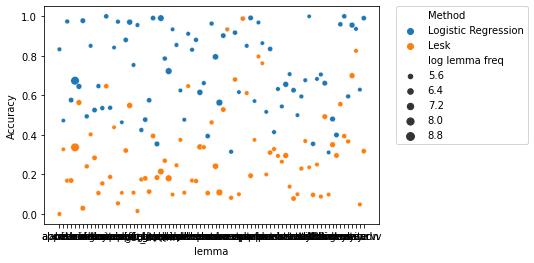

In [30]:
sns.scatterplot(data=longform_df, x='lemma', y='Accuracy', hue='Method',
               size='log lemma freq')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### What if we sort words by their frequency? Does the ML-based approach do worse with fewer examples?

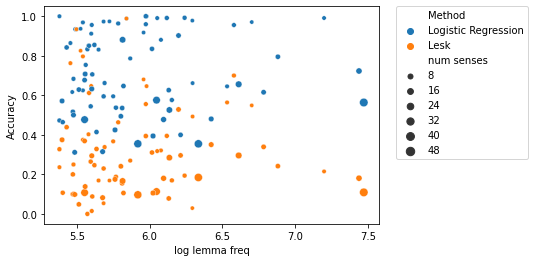

In [31]:
sns.scatterplot(data=longform_df[longform_df['log lemma freq'] < 8],  y='Accuracy', hue='Method',
               x='log lemma freq', size='num senses')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Lets try to make the relationship between accuracy and frequency more clear with a regression plot

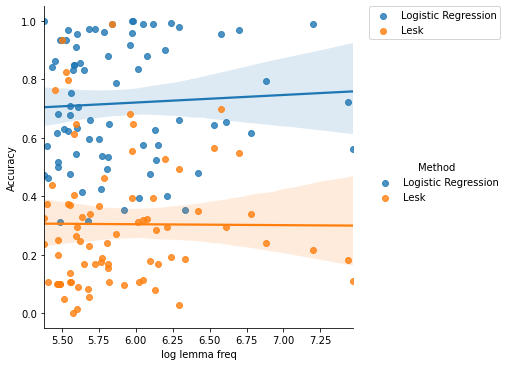

In [32]:
sns.lmplot(data=longform_df[longform_df['log lemma freq'] < 8],  y='Accuracy', hue='Method',
               x='log lemma freq')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### How about how the number of senses relates to accuracy?

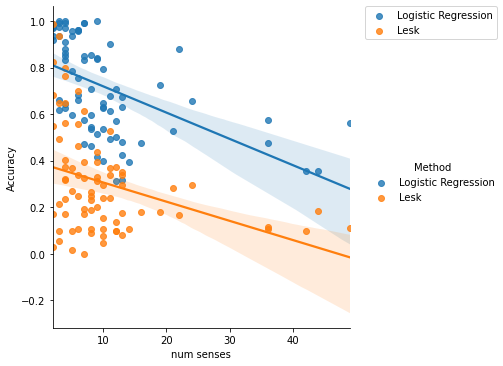

In [33]:
sns.lmplot(data=longform_df,  y='Accuracy', hue='Method', x='num senses')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Next Steps
Did you find anything interesting in comparison? What do you think is the reason(s) that contributes to your findings? Feel free to discuss and/or write your thoughts on slack.

If this exercise has sparked your interest, here's a few ideas on what you could try next:
* Try running on more rare senses in the data. When does it make sense to use Lesk versus a supervised learning approach?
* Try a more sophisticated classifier. Could you get higher performance with a RandomForest?
* In Exercise 2, you tried using dense representations, which often work well when we have short texts. It's a bit of work, but you could try loading in the googlenews vectors from Exercise do and comparing the dense representations of each context with the definition (or extended Lesk context!) to find the most similar. 
* If you're feeling very ambitions, try running on the SemEval WSD tasks, which have more data and data in languages other than English!